In [254]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, SimpleRNN, GRU, Dropout, GlobalAveragePooling1D, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.dpi": 300})
tf.keras.backend.clear_session()

Read in data and replace all instances of a slash, which indicates a new line, with a spaced slash, so that it can be tokenized.

In [255]:
data = pd.read_csv('../data/haiku.csv')
data = data.replace("/", " / ", regex=True)
data = data.dropna()
data.head()

,Unnamed: 0,id,processed_title,ups,keywords
0,0,1020ac,There's nothing inside / There is nothing outs...,5,"[('inside', 0.5268), ('outside', 0.3751), ('se..."
1,1,107cob,From whole we crumble / Forever lost to chaos ...,1,"[('chaos', 0.5962), ('crumble', 0.4749), ('for..."
2,2,109a51,Indistinctiveness / Immeasurability / Capitalism,3,"[('indistinctiveness', 0.7664), ('immeasurabil..."
3,3,10eysi,Internet is down / Obligations go bye-bye / Of...,9,"[('office', 0.5033), ('obligations', 0.4663), ..."
4,4,10f79k,Cotton in my mouth / Needles in my blood and b...,1,"[('needles', 0.5314), ('cotton', 0.4806), ('bl..."


In [256]:
def process_raw_haiku(haiku):
    tokens = tokenize(haiku)
    return " ".join(tokens)

def tokenize(sentence: str):
    tokens = sentence.lower().split()
    tokens = [process_token(t) for t in tokens]
    return tokens

def process_token(token: str):
    if token.strip() == "/":
        return token
    return re.sub(r'[^\w\s]', '', token.strip())

In [257]:
data["processed_title"] = data["processed_title"].apply(lambda x: process_raw_haiku(x))

In [258]:
data["processed_title"].head()

0    theres nothing inside / there is nothing outsi...
1    from whole we crumble / forever lost to chaos ...
2     indistinctiveness / immeasurability / capitalism
3    internet is down / obligations go byebye / off...
4    cotton in my mouth / needles in my blood and b...
Name: processed_title, dtype: object

In [259]:
corpus = data["processed_title"].to_list()
corpus[:5]

['theres nothing inside / there is nothing outside me / i search on in hope',
 'from whole we crumble / forever lost to chaos / never one again',
 'indistinctiveness / immeasurability / capitalism',
 'internet is down / obligations go byebye / office rejoices',
 'cotton in my mouth / needles in my blood and bones / hammers in my head']

In [260]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1

In [261]:
print(vocab_size)

17181


In [262]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

In [263]:
max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len = 30
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


In [264]:
# create predictors and label
x, y = input_sequences[:,:-1],input_sequences[:,-1]

In [265]:
x.shape

(176697, 29)

In [266]:
y.shape

(176697,)

In [267]:
embedding_size = 100
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_sequence_len-1),
    Bidirectional(LSTM(4)),
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

In [242]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(tf.convert_to_tensor(x), tf.convert_to_tensor(y), batch_size = 512, epochs=250, verbose=1)
#print model.summary()
print(model)

Epoch 1/5
346/346 [==============================] - 61s 164ms/step - loss: 7.3008 - accuracy: 0.0431
Epoch 2/5
346/346 [==============================] - 58s 167ms/step - loss: 6.7777 - accuracy: 0.0632
Epoch 3/5
346/346 [==============================] - 58s 167ms/step - loss: 6.5369 - accuracy: 0.0769
Epoch 4/5
346/346 [==============================] - 56s 163ms/step - loss: 6.3728 - accuracy: 0.0837
Epoch 5/5
346/346 [==============================] - 57s 163ms/step - loss: 6.2501 - accuracy: 0.0882


In [201]:
model.save("lstm")

<AxesSubplot:>

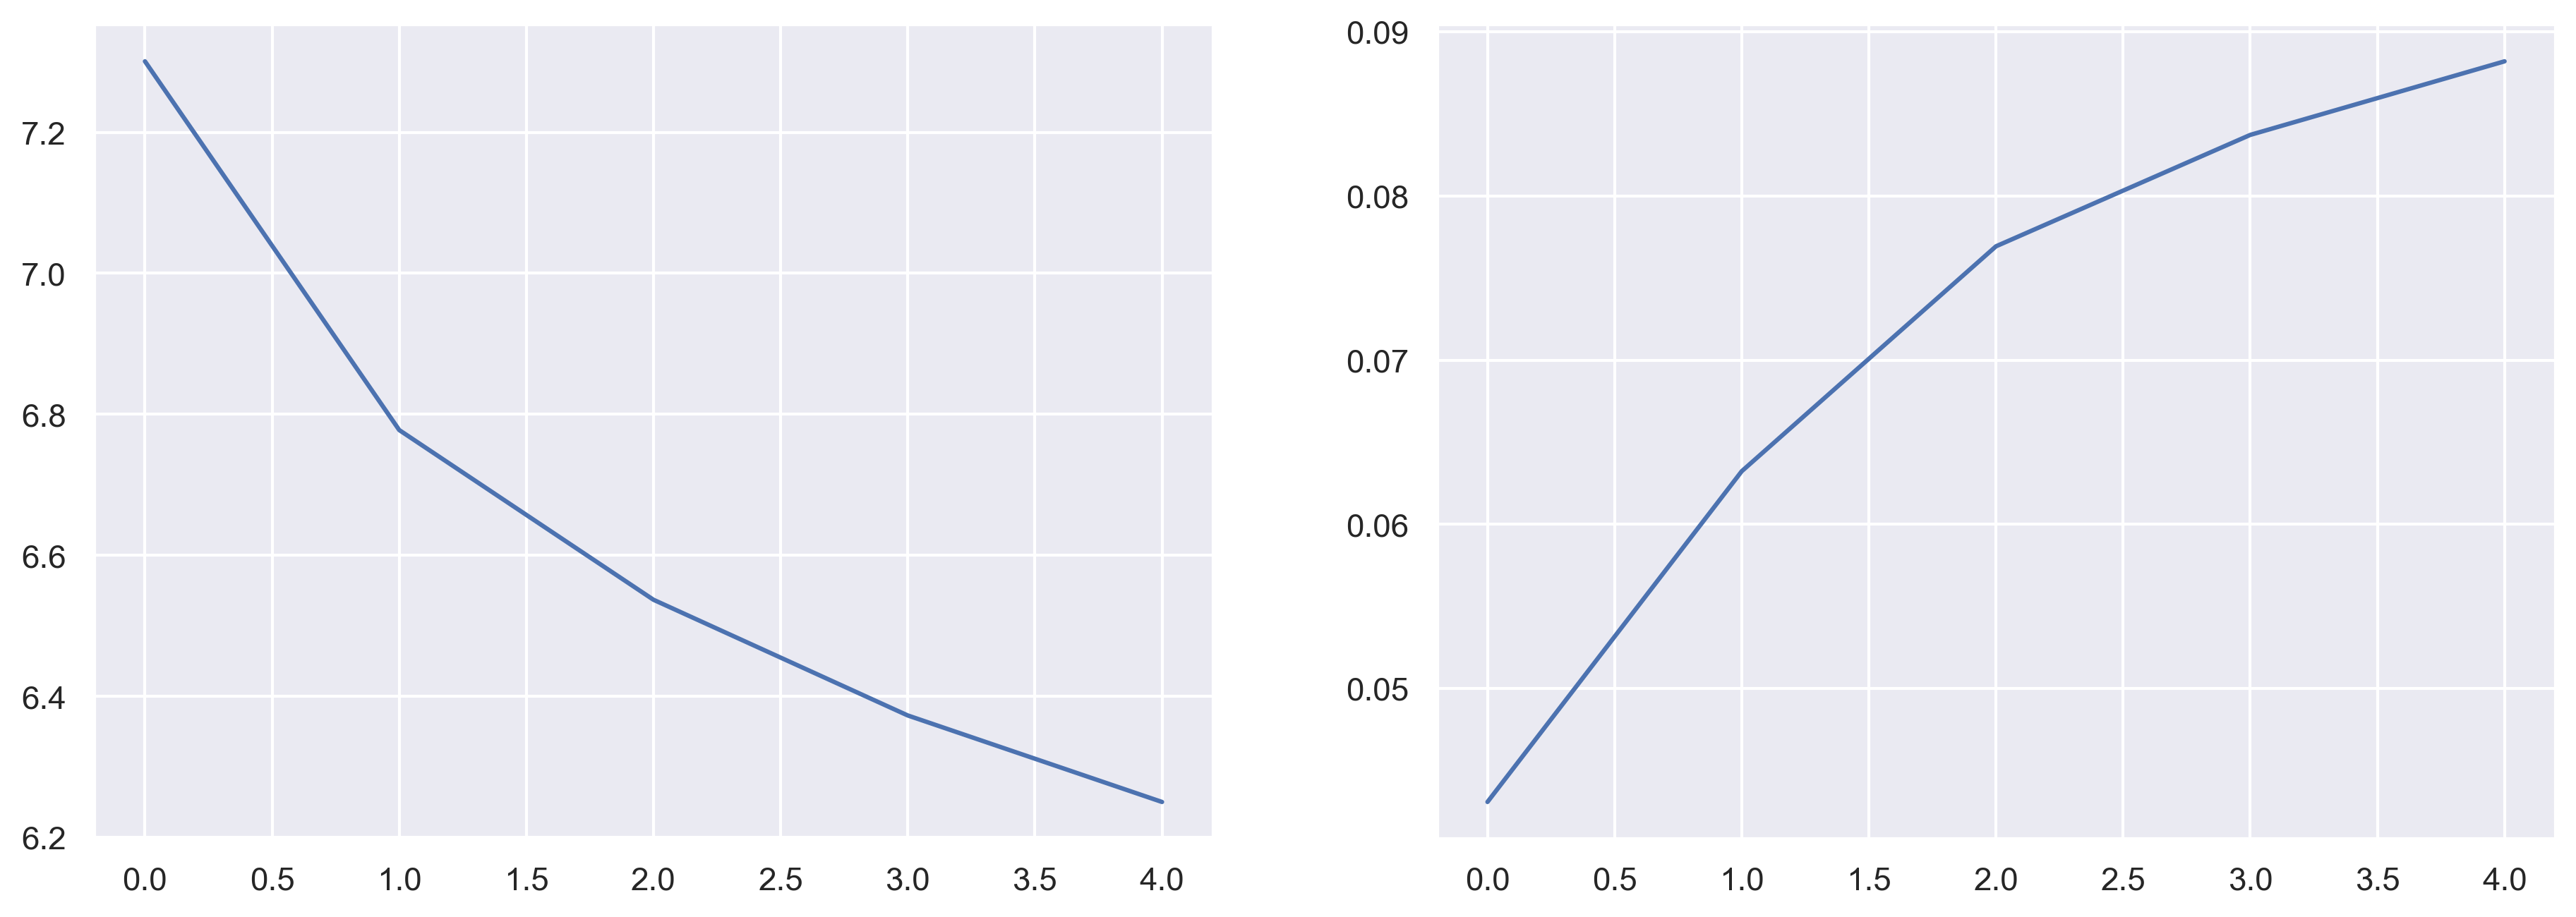

In [243]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
#losses = pd.DataFrame({"training_loss":history.history['loss'],"validation_loss":history.history['val_loss']})
# accs = pd.DataFrame({"training_accuracy":history.history['accuracy'],"validation_accuracy":history.history['val_accuracy']})
sns.lineplot(history.history['loss'], ax = ax[0])
sns.lineplot(history.history['accuracy'], ax = ax[1])

In [246]:
def generate_poem(starter_poem: str, length: int = 10):
    for _ in range(length):
        token_list = tokenizer.texts_to_sequences([starter_poem])[0]
        token_list = pad_sequences([token_list], maxlen=30-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        starter_poem += " " + output_word
    print(starter_poem)

In [247]:
generate_poem("nothing inside of my")

nothing inside of my heart is a haiku is a haiku is a haiku


In [253]:
generate_poem("this model sucks")

this model sucks to be a haiku is a haiku is a haiku
